Use U-Net for region proposals. Use conv classifier on top of that. 

1. region proposals
2. slide window approach on proposed regions, using different window sizes, differenced by 10 pixels
3. test on different images from video
4. video pipeline, smoothing over 10 frames

In [2]:
from unet import *

Using TensorFlow backend.


In [3]:
import cv2
import numpy as np
import time; import os; import pickle; import glob
import matplotlib.image as mpimg; import matplotlib.pyplot as plt
import glob 
from scipy.ndimage.measurements import label
import datetime as dt
import csv
%matplotlib inline

In [4]:
model = get_unet()
model.load_weights('./output/model_11epochs.hdf5') # dice_coeff = 0.4398

In [4]:
h, w, c = 1200, 1920, 3

In [4]:
def resize_image_for_unet(img):
    return cv2.resize(img, (w,h))

In [5]:
def select_random_frames(path='./project_video_frames/*.jpeg', n=10):
    frames = glob.glob(path)
    indices = np.random.choice(np.arange(len(frames)), n, replace=False)
    img_arr = np.zeros((n,h,w,3))
    for i,v in enumerate(indices):
        img_arr[i,] = resize_image_for_unet(mpimg.imread(frames[i]))
    return img_arr

In [91]:
img_arr = select_random_frames('./test_images/*.jpg',n=6)

In [92]:
pred_arr = model.predict(img_arr)

In [93]:
def plot_img_mask(img_arr, pred_arr):
    n = img_arr.shape[0]
    
    fig = plt.figure()
    fig.set_figwidth(8); fig.set_figheight(n*3)
    
    for i in np.arange(n): 
        img = np.array(img_arr[i,], dtype=np.uint8)
        
        ax = fig.add_subplot(n, 2, i*2+1)
        ax = plt.imshow(img)
        
        pred = np.array(pred_arr[i,]*255, dtype=np.uint8)
        pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
        pred[:,:,[1,2]] = 0*pred[:,:,1:2]
        pred = cv2.addWeighted(pred, 0.5, img, 1, 0)
        
        ax = fig.add_subplot(n, 2, i*2+2)
        ax = plt.imshow(pred)
        
    return ax

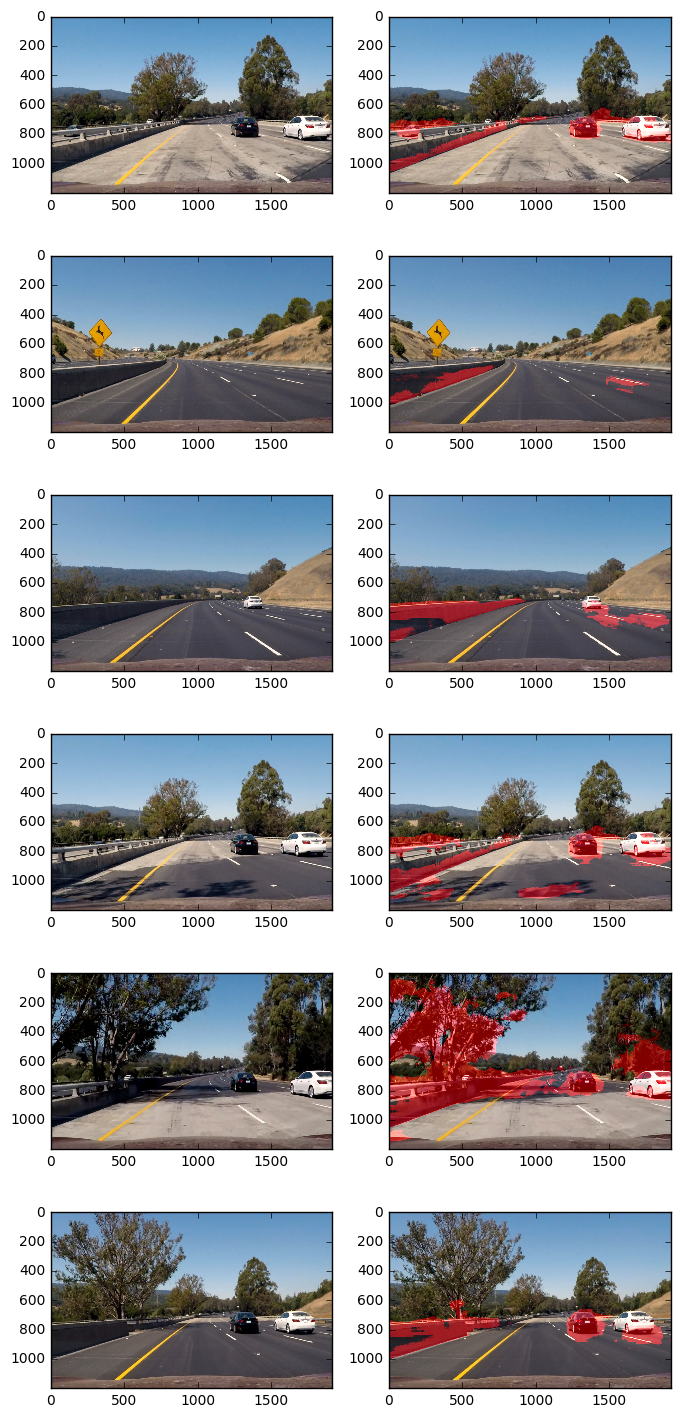

In [94]:
plot_img_mask(img_arr, pred_arr)

In [95]:
img_arr = select_random_frames('./test_images/*.jpg',n=1)
start = time.time()
pred_arr = model.predict(img_arr)
end = time.time()
print("Prediction time for one image: {}".format(end-start))

Prediction time for one image: 1.5196850299835205


#### Pipeline to process video by frame and output images and a log

In [40]:
img_arr = np.zeros((6,720,1280,3))
for i,v in enumerate(glob.glob('./test_images/*.jpg')):
        img_arr[i,] = mpimg.imread(v)

In [23]:
def draw_labeled_bboxes(img, labels, n_cars):
    # Iterate through all detected cars
    for car_number in range(1, n_cars+1):
        # Find pixels with each car_number label value
        nonzero = (labels == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img, bbox

In [330]:
def process_img(raw):
    raw_ = np.copy(raw).astype(np.uint8)
    raw_[:360,:,:] = 0
    img =  cv2.resize(raw_, (1920,1200))
    
    pred_arr = model.predict(np.expand_dims(img, 0))
    pred = pred_arr[0,:,:,-1].astype(np.uint8)
    small = cv2.resize(pred, (1280,720))
    labels, n_cars = label(small)
    small_ = draw_labeled_bboxes(small, labels, n_cars)
    small_color = cv2.cvtColor(small_, cv2.COLOR_GRAY2RGB)
    
    small_color[:,:,[1,2]] = 0*small_color[:,:,1:2]
    weighted = cv2.addWeighted(small_color.astype(np.uint8), 1, raw.astype(np.uint8), 1, 0)
    
    return weighted

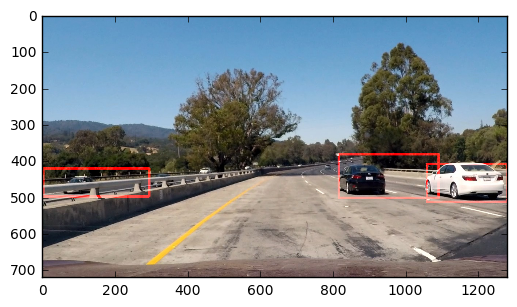

In [332]:
output = process_img(img_arr[0])
plt.imshow(output)

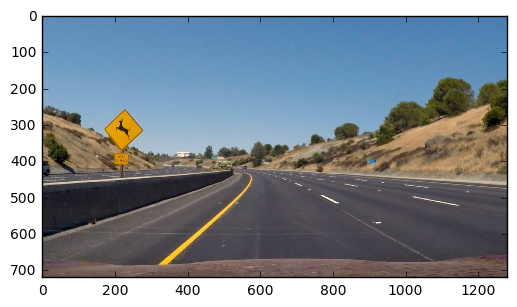

In [333]:
output = process_img(img_arr[1])
plt.imshow(output)

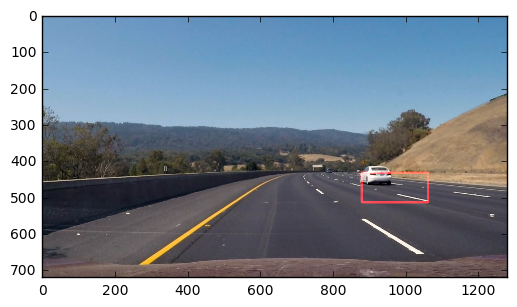

In [334]:
output = process_img(img_arr[2])
plt.imshow(output)

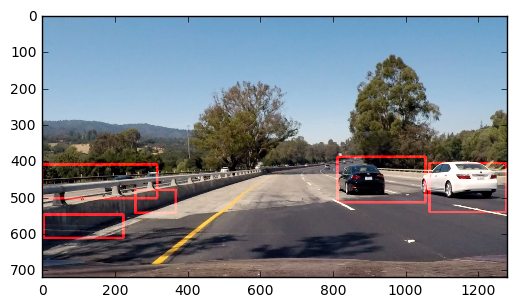

In [335]:
output = process_img(img_arr[3])
plt.imshow(output)

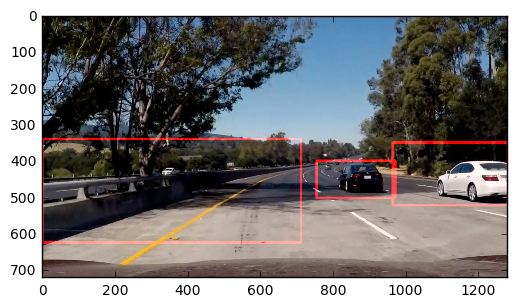

In [336]:
output = process_img(img_arr[4])
plt.imshow(output)

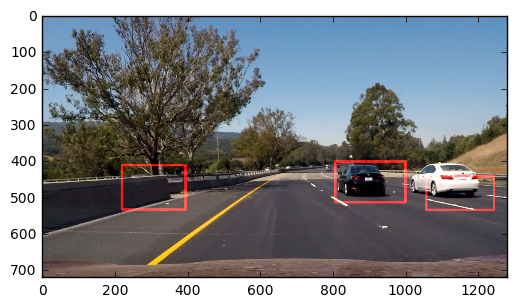

In [337]:
output = process_img(img_arr[5])
plt.imshow(output)

#### Pipeline for Diagnosis

In [9]:
def draw_labeled_bboxes(img, labels, n_cars):
    bboxes = []
    
    # Iterate through all detected cars
    for car_number in range(1, n_cars+1):
        # Find pixels with each car_number label value
        nonzero = (labels == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        
        
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image 
            bboxes.append(bbox)
            cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img, bboxes


global a
a = 0
def process_save_img(raw):
    
    global a 
    raw_ = np.copy(raw).astype(np.uint8)
    raw_[:360,:,:] = 0
    img =  cv2.resize(raw_, (1920,1200))
    
    pred_arr = model.predict(np.expand_dims(img, 0))
    pred = pred_arr[0,:,:,-1].astype(np.uint8)
    small = cv2.resize(pred, (1280,720))
    labels, n_cars = label(small)
    small_, bboxes = draw_labeled_bboxes(small, labels, n_cars)
    small_color = cv2.cvtColor(small_, cv2.COLOR_GRAY2RGB)
    
    small_color[:,:,[1,2]] = 0*small_color[:,:,1:2]
    weighted = cv2.addWeighted(small_color.astype(np.uint8), 1, raw.astype(np.uint8), 1, 0)
    
    name = str(a)+'.jpg'
    
    folder = 'test_video_frames'
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    mpimg.imsave(os.path.join(folder, name), weighted)
    a += 1
    
    writer = csv.writer(open('log_test.csv', 'a'))
    
    if len(bboxes)>0: 
        for b in np.arange(len(bboxes)): 
            row = [a, bboxes[b][0][0], bboxes[b][0][1], bboxes[b][1][0], bboxes[b][1][1]]
            writer.writerow(row)
    
    return weighted

In [10]:
from moviepy.editor import VideoFileClip
import PIL


project_video_output_fname = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_video_output = clip1.fl_image(process_save_img)
project_video_output.write_videofile(project_video_output_fname, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:23<00:02,  2.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

